In [1]:
'''
Data extracted from zip, then combined part 1 and part 2 into same folder "HAM10000_images" 
''';

In [2]:
DATA_PATH = "../../Data/"
IMAGES_PATH = DATA_PATH + "HAM10000_images/"
IMAGES_PATH_SEPARATED = DATA_PATH+"HAM10000_images_separated/"

PERFORM_IMAGE_SEPARATION = False

In [3]:
import os
import shutil
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

## Image Separation
Separating images by class into different folders to simplify manual selection of images with hair.

In [4]:
df_meta = pd.read_csv(DATA_PATH+"HAM10000_metadata.csv")
df_meta.dx.unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [5]:
if PERFORM_IMAGE_SEPARATION:
    # create folder for every class
    for dx in df_meta.dx.unique():
        try:
            os.makedirs(IMAGES_PATH_SEPARATED+dx)
        except OSError:
            pass
    # copy image into relevant folder
    for index, row in tqdm(df_meta.iterrows()):
        shutil.copy2(IMAGES_PATH+row.image_id+".jpg", IMAGES_PATH_SEPARATED+row.dx)

## EDA
Exploratory Data Analysis

In [6]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [7]:
# Main interest is diagnosys and image_id, other meta data is irrelevant to current research
data_dx = df_meta.dx.groupby(df_meta.dx).count()
data_dx

dx
akiec     327
bcc       514
bkl      1099
df        115
mel      1113
nv       6705
vasc      142
Name: dx, dtype: int64

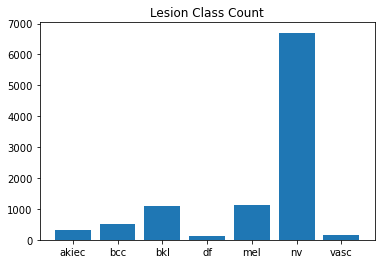

In [8]:
plt.bar(data_dx.index, data_dx.values)
plt.title("Lesion Class Count");


Here it can be seen that smalles underrepresented class "df" only has 115, while "nv" has 6705. There are 58.3 times more images of "nv" than there are images of "df". Aim is to bring data closer to ratio of 1, but with some data augmentation techniques it would not be possible, for example image can be only flipped in 3 different variations without repeats.

On other hand "mel" class has 1113 images and requires different number of augmentations of each type to reach "nv" size.

Should some augmentations be combined with each other to provide more variations and therefore decrease rаtio between "nv" and other classes?

How to deal with different number of augmentations needed? What is the aim? Same multiplier or same amount? And WHY???



In [9]:
'''
Hair Removal (Scikit image library?)
Rotation (6 degrees -> 60x, fill gaps with prevalent colour)
Cropping (pixels on side 5,10,15... (10x) crop bottop, add same to top or fill gaps with prevalent colour)
+
Flipping (H, V, H+V -> 3x)
Zooming (in: 102%,104%,106%,108%,110% -> 5x or 10x (120%) or 20x if negative zoom, squize to 30x )
Colour, Contrast, Brightness and Hue modification (?)

Generative Adversarial Networks (?)

1.
100  -> x30 -> 3000
500  -> x6  -> 3000
1000 -> x3  -> 3000
       -OR-
2.
100  -> x15 -> 1500
500  -> x15 -> 7500
1000 -> x15 -> 15000

Picking first option from above as otherwise same problem of underrepresentation persists.

akiec     327   -> x18  -> 5886
bcc       514   -> x12  -> 6168
bkl      1099   -> x6   -> 6594
df        115   -> x36  -> 4140  or x18 -> 2070
mel      1113   -> x6   -> 6678 
nv       6705   NA
vasc      142   -> x36  -> 5112  or x18 -> 2556

41,283 (34,578 without nv [if x18 29,952]) 

10% validation ?

MIN and MAX augmentation values will be the same, 
number of steps in the middle will be different for each class.

''';


## TODO: Separate images with hair and get their names

Table below shows how many images with hair were found among each class with percentage. The core idea is to feed same amount of images to a neural network in first test (T1) and in second test (T2), with the difference of T1 has no hair images and T2 has images containing hair in the same proportion as original data classes. Then, once models are fitted, aim is to predict images having hair and observe the results. Initial assumption is T2 model would perform better in classification of images with hair and T1 would perform worse. That would ... in debate whether hair has to be removed from skin lesion images at all.


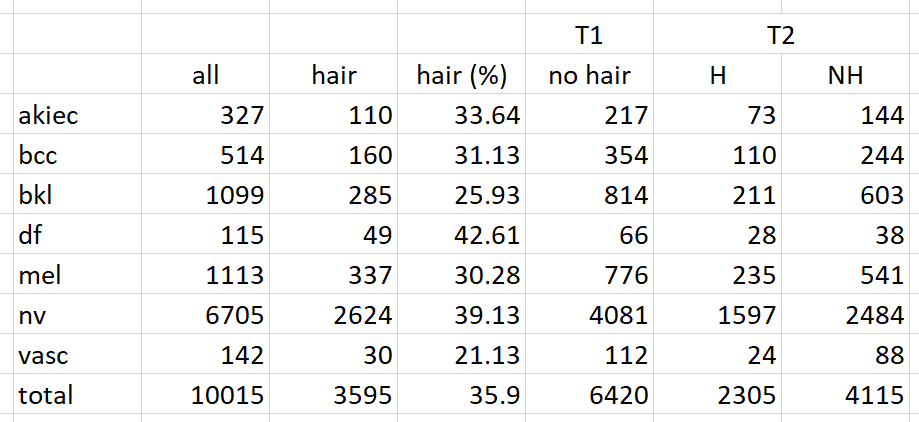

Table below shows different options considered in order to perform augmentation process. Second options N amplitude is less, and total number of images is less, in comparison. With original model training it was revealed that fitting takes even more time then expected. With increasing number of images fitting might take even more time. There are 5 models planned with 20K images, original model with 9K and 2 models for hair (T1 and T2) each with 6420 images. 8 models for CNN all together (+GAN model). KFolds iteration number was decreased from 10 to 5 to minimize time it takes for model training.

Each augmentation will produce same amount of data (total of 19190 images), this approach will allow to compare augmentations among each other and between original model.

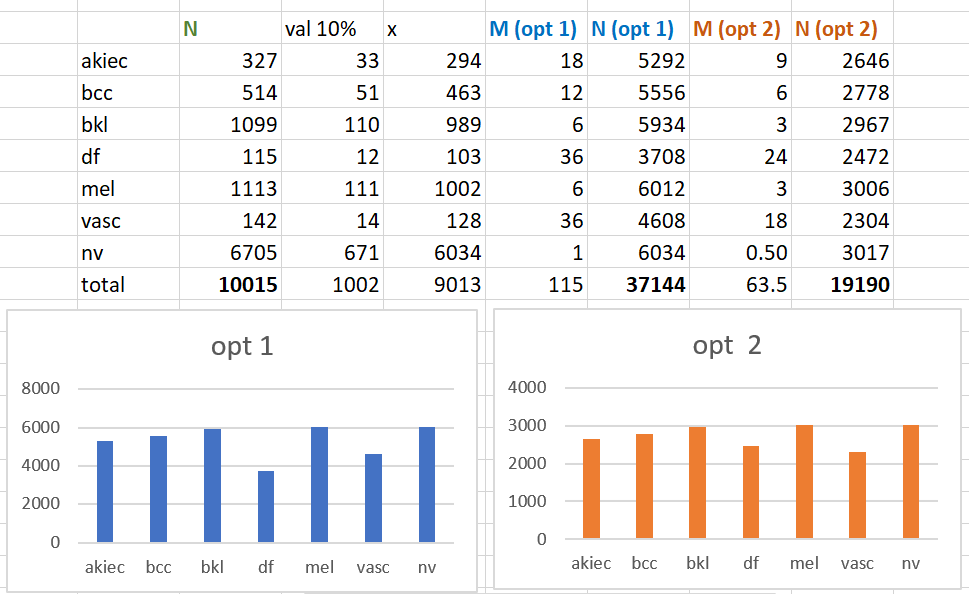